In [1]:
from scipy.stats import chi2, norm
from scipy.special import logsumexp
from matplotlib.pyplot import *
import numpy as np
import emcee, corner
import globalDetFunctions as gd
import LightkurveCacheAccess as lkAcc
import pandas as pd
import lightkurve as lk

In [11]:
download_dir = '/home/nielsemb/.lightkurve-cache'

ID = 'KIC8006161'
mission = 'Kepler'
cadence = 'short'
Teff = 5115
numaxGuess = np.random.normal(3500, 0.5*3500)

#x, y, y_err = np.genfromtxt('/home/nielsemb/Downloads/HD79620_eleanor.csv', delimiter = ',').T
#lc = lk.LightCurve(time=x, flux=y, targetid=ID).remove_nans()

f, p, b = gd.tsToPsd(ID, download_dir, mission='Kepler', cadence=cadence)

--formatting name
--setting mission
--getting mast identifier
--performing search
--checking cache
--loading fits
---Loading files
---No of files 39
['/home/nielsemb/.lightkurve-cache/mastDownload/Kepler/kplr008006161_sc_Q001003333333333332/kplr008006161-2009231120729_slc.fits', '/home/nielsemb/.lightkurve-cache/mastDownload/Kepler/kplr008006161_sc_Q001003333333333332/kplr008006161-2010111051353_slc.fits', '/home/nielsemb/.lightkurve-cache/mastDownload/Kepler/kplr008006161_sc_Q001003333333333332/kplr008006161-2010140023957_slc.fits', '/home/nielsemb/.lightkurve-cache/mastDownload/Kepler/kplr008006161_sc_Q001003333333333332/kplr008006161-2010174090439_slc.fits', '/home/nielsemb/.lightkurve-cache/mastDownload/Kepler/kplr008006161_sc_Q001003333333333332/kplr008006161-2010203174610_slc.fits', '/home/nielsemb/.lightkurve-cache/mastDownload/Kepler/kplr008006161_sc_Q001003333333333332/kplr008006161-2010234115140_slc.fits', '/home/nielsemb/.lightkurve-cache/mastDownload/Kepler/kplr008006161_sc

In [12]:
fb, pb, bb, dfb, Nbin = gd.binTheSpectrum(f, p, b, freqBinSize = 400)

In [13]:
#N, C = getSummedAcfMuCov(acf, 10, sparse = False)
lags, acf = gd.getTrimmedACF(f, p, b, freqBinSize = 0.5)
C = np.std(acf[-5:])

In [20]:
print(numaxGuess)
nwalkers=50
numax_i = np.random.normal(numaxGuess, max(20, 0.5*numaxGuess), nwalkers)
idx = (numax_i < fb[0]) + (numax_i > fb[-1])
while len(numax_i[idx]) > 0:
    numax_i[idx] = np.random.normal(numaxGuess, max(20, 0.5*numaxGuess), len(numax_i[idx]))
    idx = (numax_i < fb[0]) + (numax_i > fb[-1])
dnu_i = gd.dnuScale(numax_i)
H_i = max(acf[5:]) + 1e-2*np.random.randn(nwalkers)
w_i = np.log10(0.2) + 1e-2*np.random.randn(nwalkers)
B_i = np.mean(acf[-5:]) + 1e-2*np.random.randn(nwalkers)
pos = np.vstack((numax_i, dnu_i, H_i,w_i,B_i)).T

5451.069720615481


In [24]:
for i in range(50):
    theta = pos[i,:]
    print(pos[i,:])
    gd.logProbEmcee(theta, fb, pb, bb, Nbin, f[-1], lags, acf, C, Teff, numaxGuess)
    

[ 5.51454674e+03  1.85600715e+02  4.53241987e+02 -6.91177550e-01
 -1.99948495e+01]
[ 6.92862545e+03  2.20471332e+02  4.53254339e+02 -6.92988751e-01
 -2.00009824e+01]
[ 8.10933792e+03  2.48253316e+02  4.53224316e+02 -7.03208733e-01
 -1.99838785e+01]
[ 6.98405480e+03  2.21800329e+02  4.53235892e+02 -6.94630315e-01
 -1.99978879e+01]
[ 6.81913517e+03  2.17838437e+02  4.53246114e+02 -7.10951818e-01
 -1.99930399e+01]
[ 3.69619608e+03  1.37255016e+02  4.53261242e+02 -7.05294393e-01
 -1.99921056e+01]
[ 5.63078266e+03  1.88543770e+02  4.53254660e+02 -7.07215273e-01
 -1.99859550e+01]
[ 6.91888686e+03  2.20237566e+02  4.53249719e+02 -6.78011410e-01
 -1.99942487e+01]
[ 5.75329672e+03  1.91629671e+02  4.53254132e+02 -6.73821706e-01
 -1.99864093e+01]
[ 2.60520692e+03  1.05426738e+02  4.53240092e+02 -6.98463762e-01
 -1.99924839e+01]
[ 5.80985555e+03  1.93048821e+02  4.53256962e+02 -6.87505188e-01
 -1.99813144e+01]
[ 7.15853013e+03  2.25966833e+02  4.53231087e+02 -6.98743628e-01
 -1.99924516e+01]
[ 5.

(array([ 87., 122., 246., 382., 506., 686., 801., 783., 759., 628.]),
 array([ 18.08999172,  41.42601262,  64.76203352,  88.09805443,
        111.43407533, 134.77009623, 158.10611713, 181.44213803,
        204.77815893, 228.11417984, 251.45020074]),
 <a list of 10 Patch objects>)

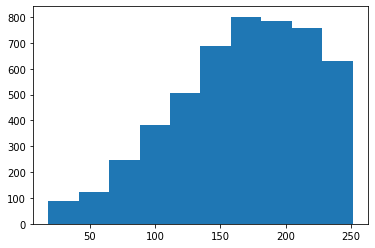

In [22]:
hist(pos[:,1])

In [25]:
samples = gd.runSampler(fb, pb, bb, Nbin, f[-1], lags, acf, C, Teff, numaxGuess, gd.logProbEmcee, 5, progress=False, bsteps=2000)

/home/nielsemb/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


In [ ]:
true_dnu = 149.365

fsamples = samples.reshape((-1, 5))
percs = np.percentile(fsamples, [16, 50, 84], axis = 0)
figT, axT = subplots(3,2, figsize = (16,7))

axT[0,0].plot(fb, pb/bb)
axT[0,0].set_xlim(min(fb), max(fb))
axT[0,0].set_ylim(min(pb/bb), max(pb/bb))
axT[0,0].axvline(numaxGuess, color = 'C4')
axT[0,0].fill_betweenx([0, max(pb/bb)], percs[0,0], percs[2,0], color = 'C3', alpha = 0.2)

print(percs[0,0], percs[2,0])

axT[0,1].plot(lags, acf)
for m in np.random.randint(0, len(fsamples[0]), 50):
    _dnu, _H, _w, _B = fsamples[m,1:]
    _w = 10**_w
    axT[0,1].plot(lags, gd.lorentz(lags, acf, _dnu, _H, _w, _B), color = 'C3', alpha = 0.1)
    
axT[0,1].axvline(true_dnu, color = 'C4')
axT[0,1].set_xlim(min(lags), min([10*true_dnu, max(lags)]))
axT[0,1].fill_betweenx(axT[0,1].get_ylim(), percs[0,1], percs[2,1], color = 'C3', alpha = 0.1)

axT[1,0].plot(range(np.shape(samples)[0]), samples[:, :, 0], "k", alpha=0.3)
axT[1,0].set_xlim(0, len(samples))
axT[1,0].set_ylabel("numax")   
axT[1,0].set_xlabel("step number");   
axT[1,0].axhline(numaxGuess, color = 'C4')


axT[1,1].plot(range(np.shape(samples)[0]), samples[:, :, 1], "k", alpha=0.3)
axT[1,1].set_xlim(0, len(samples))
axT[1,1].set_ylabel("dnu")   
axT[1,1].set_xlabel("step number");   
axT[1,1].axhline(true_dnu, color = 'C4')


lnpn = np.array([gd.numaxLogProbability(nu, fb, pb, bb, Teff, Nbin, fb[-1], numaxGuess) for nu in fb])

axT[2,0].plot(fb, np.sum(lnpn, axis = 1))

In [ ]:
rcParams['font.size'] =14
fig, ax = subplots(figsize = (11,7))

ax.plot(lags, acf, label = 'Spectrum ACF')
for i, m in enumerate(np.random.randint(0, len(fsamples[0]), 50)):
    _dnu, _H, _w, _B = fsamples[m,1:]
    _w = 10**_w
    if i == 0:
        ax.plot(lags, gd.lorentz(lags, acf, _dnu, _H/2, _w, _B), color = 'C3', alpha = 1, label = 'ACF model')
    ax.plot(lags, gd.lorentz(lags, acf, _dnu, _H/2, _w, _B), color = 'C3', alpha = 0.1)
    
ax.legend()
#ax.axvline(true_dnu, color = 'C4')
ax.set_xlim(min(lags), 300)
#ax.fill_betweenx(ax.get_ylim(), percs[0,1], percs[2,1], color = 'C3', alpha = 0.1)
ax.set_xlabel(r'Lag [$\mu$Hz]')
ax.set_ylabel(r'Autocorrelation')
fig.tight_layout()
fig.savefig('ACF_doris.png')

In [ ]:
import astropy.convolution as conv

def smoothing(f, s, size = 0.5):
    fac = max([1, size / (f[1] - f[0])])
    kernel = conv.Gaussian1DKernel(stddev=fac)
    return conv.convolve(s, kernel)

smoo = smoothing(f, p)
rcParams['font.size'] = 16
fig, ax = subplots(figsize = (16,9))
ax.plot(f,smoo/b, lw = 2)
ax.set_xlim(3250,3750)
ax.set_xlabel('Frequency [$\mu$Hz]')
ax.set_ylabel('SNR')
fig.tight_layout()
fig.savefig('dnu_example.png')

In [ ]:
from tqdm import tqdm

L = np.zeros((len(fb), len(lags)))

for i, nu in enumerate(fb):
    for j, lag in enumerate(lags):
 
        theta = [nu, lag, max(acf[5:]), np.log10(0.2), np.mean(acf[-5:])]

        logp_dnu = gd.dnuLogProbability(theta[1:], lags, acf, C)          
        
        logp_numax = gd.numaxLogProbability(theta[0], fb, pb, bb, Teff, Nbin, f[-1], numaxGuess)  
        
        logp_dnuNumaxPrior = gd.dnuNumaxPrior(theta[0], theta[1])
        
        L[i, j] = np.sum(logp_numax) + logp_dnu #+ logp_dnuNumaxPrior

In [ ]:
import pandas as pd
df = pd.read_csv('/home/nielsemb/work/repos/PBjam/pbjam/data/prior_data.csv')

In [ ]:
idxfb = np.argmin(abs(fb - 5000))
idxlags = np.argmin(abs(lags - 200))
vmin, vmax = np.amin(L[:idxfb, :idxlags]), np.amax(L[:idxfb, :idxlags])

In [ ]:
vmax

In [ ]:
rcParams['font.size'] = 14

fig, ax = subplots(figsize=(9,7))
ax.contourf(fb, lags, L.T, vmin=vmin, vmax=vmax)
ax.set_xlabel(r'$\nu_{max}$')
ax.set_ylabel(r'$\Delta\nu$')
ax.set_ylim(0,200)
ax.set_xlim(fb[0], 5000)

#ax.scatter(10**df['numax'], 10**df['dnu'], c = 'k', s = 4)

#ax.plot(fb, gd.dnuScale(fb), color = 'C3', lw = 3)
#ax.plot(fb, gd.dnuScale(fb)*(1+0.21), color = 'C3', ls = 'dashed')
#ax.plot(fb, gd.dnuScale(fb)*(1-0.21), color = 'C3', ls = 'dashed')
fig.tight_layout()
fig.savefig('dnu_numax_loglikelihood_0_prior.png')
#fig.savefig('dnu_numax_loglikelihood_1_prior.png')
#fig.savefig('dnu_numax_loglikelihood_2_prior.png')
#Dnu / dnuScale(numax)-1


In [ ]:
SNR, SNR_pred, dof = np.array([gd.getSNR(nu, fb, pb, bb, Teff, f[-1], Nbin) for nu in fb]).T

lnpn = np.array([gd.numaxLogProbability(nu, fb, pb, bb, Teff, Nbin, fb[-1], numaxGuess) for nu in fb])

In [ ]:
plot(fb, 1+SNR)

In [ ]:
fig, ax = subplots(figsize = (16,9))
ax.plot(fb,  np.sum(lnpn, axis = 1))
    
#logp_H0 = -chi2.logpdf((1+SNR), df=dof, scale=1./dof) #gd.chi2logcdf((1+SNR), df=dof, scale=1./dof)

#logp_H1 = -chi2.logsf((1+SNR)/(1+SNR_pred), df=dof, scale=1./dof)
#ax.plot(fb, )
#     
#     
#     ax[1].plot(nu, logp_threshold, 'k.')
#     ax[2].plot(nu, logp_H1, 'k.')
#     ax[3].plot(nu, logp_H0, 'k.')
#     ax[4].plot(nu, logp_bkgRatio, 'k.')
    #ax[2].plot(nu, , 'k.')
#ax.set_ylim(-1,1)

In [ ]:
import warnings
fsamples = samples.reshape((-1,ndim))
#with warnings.catch_warnings():
#    warnings.simplefilter("ignore")
fig = corner.corner(fsamples, truths = [numax_guess, 16.9, None, None, None], labels = ['numax', 'dnu', 'H', 'w', 'B']);
#fig.savefig('test.png')

28.50780290287453
0.07273238242461666


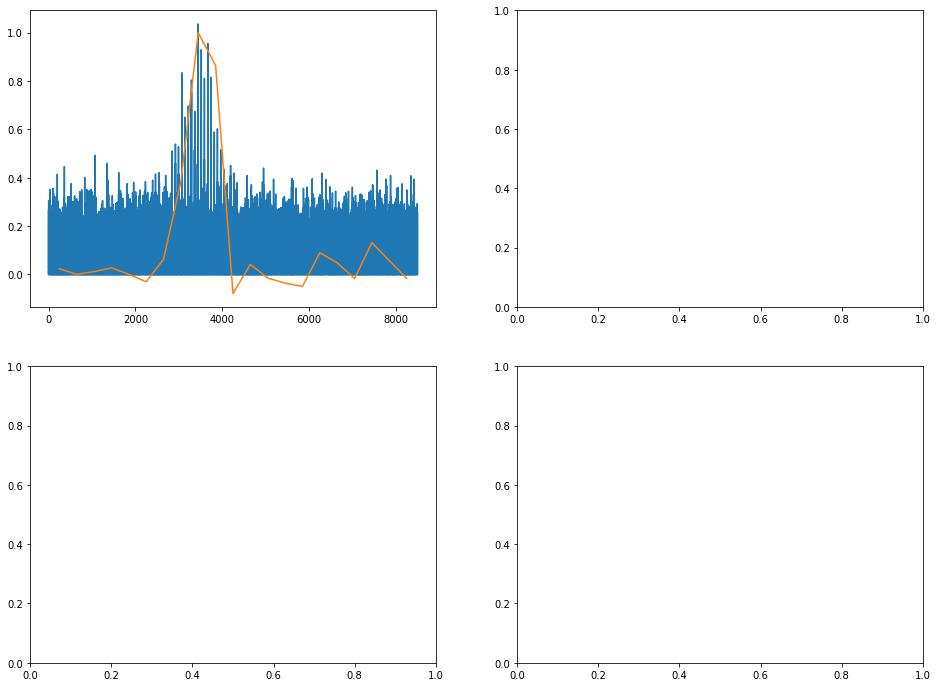

In [40]:
burn = 0

# logp_numax, logp_thresh, logp_H1, logp_H0, logp_bkgRatio = np.zeros_like(fb),np.zeros_like(fb), np.zeros_like(fb), np.zeros_like(fb), np.zeros_like(fb)
# for i in range(len(fb)):     
#     logp_numax[i], logp_thresh[i], logp_H1[i], logp_H0[i], logp_bkgRatio[i] = gd.numaxLogProbability(fb[i], fb, pb, bb, Teff, dfb, Nbin, f[-1], numaxGuess)   
# joint_likelihood = logp_H1+logp_H0   
# joint_prior = logp_numax+logp_thresh+logp_bkgRatio
# posterior = logp_numax+logp_thresh+logp_H1+logp_H0    
    
fig, axes = subplots(2, 2, figsize=(16, 12))
print(max(p/b)  -min(p/b  ))
print(max(pb/bb)  -min(pb/bb  ))
axes[0,0].plot(f,  (p/b-min(p/b)) / (max(p/b)-min(pb/pb)), color = 'C0', label = 'SNR spectrum')
axes[0,0].plot(fb, (pb/bb-min(pb/pb)) / (max(pb/bb)-min(pb/pb)), color = 'C1', label = 'SNR spectrum')
#axh = axes[0,0].twinx()
#axh.hist(samples[burn:,:,0].flatten(), bins = 40, color = 'C1', alpha = 0.5, label = 'Posterior distribution')
#axh.set_yticks([])
# axes[0,0].set_xticks([])
# axes[0,0].set_ylabel(r'Probability')
# axes[0,0].axvline(numax_guess, color = 'C4', alpha = 0.5)
# # for x in percs:
# #     axes[0,0].axvline(x, color = 'C3', alpha = 0.5, ls = 'dotted')
# axes[0,0].set_xlim(f[0],f[-1])
# axes[0,0].legend()
    
# axes[0,1].plot(fb, logp_H0, color = 'C0', label = r'$-\mathcal{L}(H0)$')
# axes[0,1].plot(fb, logp_H1, color = 'C1', label = r'$\mathcal{L}(H1)$')
# axes[0,1].plot(fb, joint_likelihood, color = 'C3', label = r'Joint likelihood')
# axes[0,1].legend()
# axes[0,1].set_ylim(max([-50, axes[0,1].get_ylim()[0]]), 
#                    max([max(logp_H0), max(logp_H1), max(joint_likelihood)])+1)   
# axes[0,1].set_xticks([])
# axes[0,1].set_xlim(f[0],f[-1])

# axes[1,1].plot(fb, logp_numax, color = 'C0', label = r'$p(\nu_{max})$ given $T_{\mathrm{eff}}$, $\varpi$ and $L$')
# axes[1,1].plot(fb, logp_thresh, color = 'C1', label = r'0.01 False alarm prior.')
# axes[1,1].plot(fb, logp_bkgRatio, color = 'C2', label = r'Bkg ratio prior')
# axes[1,1].plot(fb, joint_prior, color = 'C3', label = 'Joint prior')
# axes[1,1].legend()
# axes[1,1].set_ylim(max([-50, axes[1,1].get_ylim()[0]]), 
#                    max([max(logp_numax), max(logp_thresh), max(logp_bkgRatio), max(joint_prior)])+1)   
# axes[1,1].set_xlabel(r'$\nu_{max}$ [$\mu$Hz]')
# axes[1,1].set_xlim(f[0],f[-1])

# axes[1,0].plot(fb, joint_likelihood, color = 'C0', label = r'Joint likelihood')
# axes[1,0].plot(fb, joint_prior, color = 'C1', label = 'Joint prior')
# axes[1,0].plot(fb, posterior, color = 'C3', label = 'Total probability')
# axes[1,0].legend()
# axes[1,0].set_ylim(max([-50,  axes[1,0].get_ylim()[0]]), 
#                    max([max(joint_likelihood), max(joint_prior), max(posterior)])+1)   
# axes[1,0].set_xlabel(r'$\nu_{max}$ [$\mu$Hz]')
# axes[1,0].set_ylabel(r'Probability')
# axes[1,0].set_xlim(f[0],f[-1])
# fig.tight_layout()


In [ ]:
figT, axT = subplots(2,2, figsize = (16,7))
axT[0,0].plot(fb, pb/bb)
axTh = axT[0,0].twinx()
axTh.hist(samples[burn:, :, 0].flatten(), bins = np.linspace(min(fb), max(fb), 100), color = 'C2')
axTh.set_yticks([])

axT[0,1].plot(lags, acf)
axTa = axT[0,1].twinx()
axTa.hist(samples[burn:, :, 1].flatten(), bins = np.linspace(min(lags), max(lags), 100), color = 'C2')
axTa.set_yticks([])

axT[1,0].plot(range(0,nsteps), samples[:, :, 0], "k", alpha=0.3)
#axT[1,0].plot(range(0,burn),samples[:burn, :, 0], "C1", alpha=0.3)
axT[1,0].set_xlim(0, len(samples))
axT[1,0].set_ylabel("numax")   
axT[1,0].set_xlabel("step number");   

axT[1,1].plot(range(0,nsteps), samples[:, :, 1], "k", alpha=0.3)
#axT[1,1].plot(range(0,burn),samples[:burn, :, 1], "C1", alpha=0.3)
axT[1,1].set_xlim(0, len(samples))
axT[1,1].set_ylabel("dnu")   
axT[1,1].set_xlabel("step number");   

In [ ]:
fsamples = samples[burn:,:,:].reshape((-1, ndim))
percs = np.percentile(fsamples, [16, 50, 84], axis = 0)
print(percs[0,:], np.median(np.diff(percs, axis = 0), axis = 0))

In [ ]:
np.diff(percs, axis = 0)

In [1]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import *
tgt_list = pd.read_csv('/home/nielsemb/work/Bluebear_projects/getGlobal/getGlobalResults.csv')

In [2]:
idx = np.isnan(tgt_list['numax_p50'])
tgtListRed = tgt_list[~idx]

In [3]:
pbjamPrior = pd.read_csv('/home/nielsemb/work/repos/PBjam/pbjam/data/prior_data.csv')

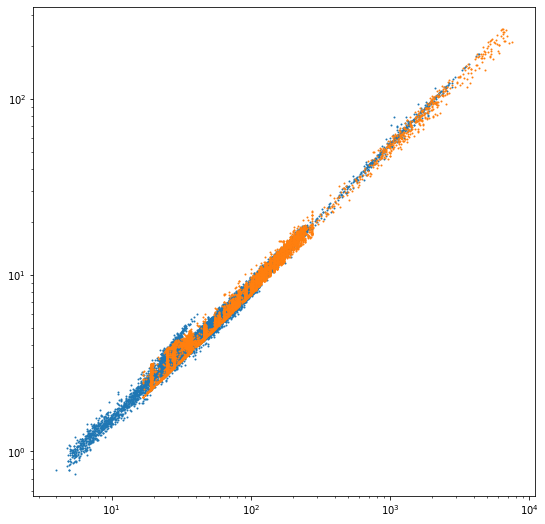

In [4]:
fig, ax = subplots(figsize = (9,9))

ax.scatter(tgtListRed['numax'], tgtListRed['dnu'], s = 1)
ax.scatter(tgtListRed['numax_p50'], tgtListRed['dnu_p50'], s =1)
#ax.plot(fb, gd.dnuScale(fb)*(1+0.21), color = 'C3', ls = 'dashed')
#ax.plot(fb, gd.dnuScale(fb)*(1-0.21), color = 'C3', ls = 'dashed')
ax.set_yscale('log')
ax.set_xscale('log')

In [5]:
serenelli = pd.read_csv('/home/nielsemb/work/Target_lists/serenelli_tgts.csv')
serenelli['ID'] = ['KIC'+str(i) for i in serenelli['ID']]

In [6]:
serenelli

,ID,teff,teff_error,dnu,dnu_error,numax,numax_error,bp_rp
0,KIC11401708,5661.5,69.276,40.161,0.296,672.048,18.942,0.829402
1,KIC9908400,5961.1,69.276,36.624,0.231,650.286,23.283,0.747497
2,KIC8360349,6325.5,69.276,40.760,0.274,739.636,18.896,0.679888
3,KIC8367710,6066.3,69.276,55.607,0.467,1032.560,27.584,0.670490
4,KIC9226926,6478.8,69.276,73.274,0.564,1610.118,42.436,0.536106
...,...,...,...,...,...,...,...,...
428,KIC12069569,6357.0,59.000,44.687,2.162,737.053,102.768,NaN
429,KIC12117868,6160.0,51.000,93.695,3.943,1859.173,186.779,NaN
430,KIC12265063,6189.0,60.000,67.875,2.498,1324.832,232.036,NaN
431,KIC12317678,6549.0,48.000,63.573,0.089,1248.595,14.625,NaN


(-0.2, 0.5)

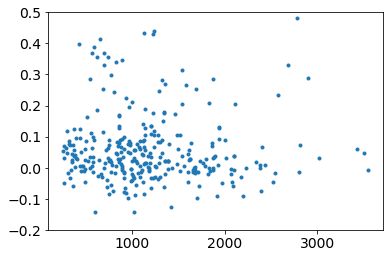

In [17]:
serenelli['r'] = np.nan
from shutil import copyfile
figure()
for i in serenelli.index:
    idx = tgtListRed['ID']==serenelli.loc[i, 'ID']
    
    err = np.sqrt(serenelli.loc[i, 'numax_error']**2 + 
                  ((tgtListRed.loc[idx,'numax_p84']-tgtListRed.loc[idx,'numax_p16'])/2)**2)

    r = (tgtListRed.loc[idx,'numax_p50']/serenelli.loc[i, 'numax']-1)#/err
    
    plot(serenelli.loc[i, 'numax'], r, '.', color = 'C0')
    
#     ID = serenelli.loc[i, 'ID']
    
#     if abs(abs(r.values)[0]) > 1:
#         src = f'/home/nielsemb/work/Bluebear_projects/getGlobal/Results/{ID}_res.png'
#         dst = f'/home/nielsemb/work/repos/PSM128/getGlobal/Results/{ID}_res.png'
        
#         copyfile(src,dst)
    
    
    
#     plot(tgtListRed.loc[idx,'numax_p50'], tgtListRed.loc[idx,'dnu_p50'], '.', color='C1')
    
ylim(-0.2,0.5)

/home/nielsemb/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'r_Teff' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/nielsemb/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'r_[Fe/H]' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


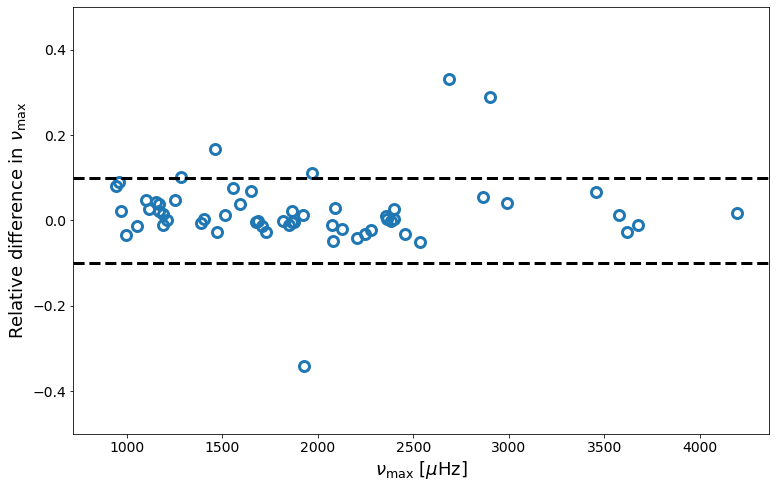

In [36]:
from astropy.table import Table


rcParams['font.size'] = 14

lund = Table.read("ftp://cdsarc.u-strasbg.fr/ftp/J/ApJ/835/172/table1.dat",
               readme="ftp://cdsarc.u-strasbg.fr/ftp/J/ApJ/835/172/ReadMe",
               format="ascii.cds").to_pandas()

lund = lund[['KIC','numax', 'Dnu', 'Teff', 'e_Teff']]
lund['KIC'] = ['KIC'+str(int(x)) for x in lund.KIC]
lund = lund.rename(columns = {'KIC': 'ID', 'Teff':'teff', 'e_Teff': 'teff_err', 'Dnu': 'dnu'})
lund['cadence'] = 'short'
fig, ax = subplots(figsize = (11,7))

for i in lund.index:
    idx = tgtListRed['ID']==lund.loc[i, 'ID']
    
    ID = lund.loc[i,'ID']
       
    if len(tgtListRed.loc[idx,'ID'])==0:
        continue
    
    r = (tgtListRed.loc[idx,'numax_p50']- lund.loc[i, 'numax'])/lund.loc[i, 'numax']

    ax.plot(lund.loc[i, 'numax'], r, 'o', color = 'C0', markerfacecolor = 'None', ms =10, markeredgewidth=3)

    
    if abs(abs(r.values)[0]) > 0.1:
        src = f'/home/nielsemb/work/Bluebear_projects/getGlobal/Results/{ID}_res.png'
        dst = f'/home/nielsemb/work/repos/PSM128/getGlobal/Results/{ID}_res.png'
        
        copyfile(src,dst)

        
ax.axhline(0.1, ls = 'dashed', color = 'k', lw=3)
ax.axhline(-0.1, ls = 'dashed', color = 'k', lw=3)
ax.set_ylabel(r'Relative difference in $\nu_{\mathrm{max}}$', fontsize = 18)
ax.set_xlabel(r'$\nu_{\mathrm{max}}$ [$\mu$Hz]', fontsize = 18)

ax.set_ylim(-0.5, 0.5)
fig.tight_layout()
fig.savefig('Legacy_comparison.png')

In [37]:
lund.to_csv('legacyList.csv', index=False)

In [ ]:
pdf = pd.read_csv('')

In [10]:
rnumax = tgtListRed['numax_p50']/tgtListRed['numax']-1
rdnu = tgtListRed['dnu_p50']/tgtListRed['dnu']-1

limit = 0.1

idxtotal = np.sqrt(rnumax**2 + rdnu**2) < limit
idxnumax = abs(rnumax) < limit
idxdnu = abs(rdnu) < limit 

recoveryNumax = len(tgtListRed[idxnumax])/len(tgtListRed)
recoveryDnu = len(tgtListRed[idxdnu])/len(tgtListRed)

In [11]:
recoveryNumax

0.4875724163707718

Text(0, 0.5, 'Relative dnu')

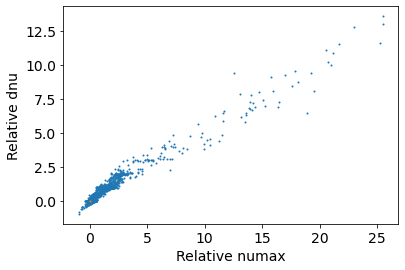

In [12]:
from matplotlib.pyplot import *
figure()
scatter(rnumax, rdnu, s=1)
scatter(rnumax[idx], rdnu[idx], s=1)
xlabel('Relative numax')
ylabel('Relative dnu')
#xlim(-2,2)
#ylim(-2,2)

(-1.0, 1.0)

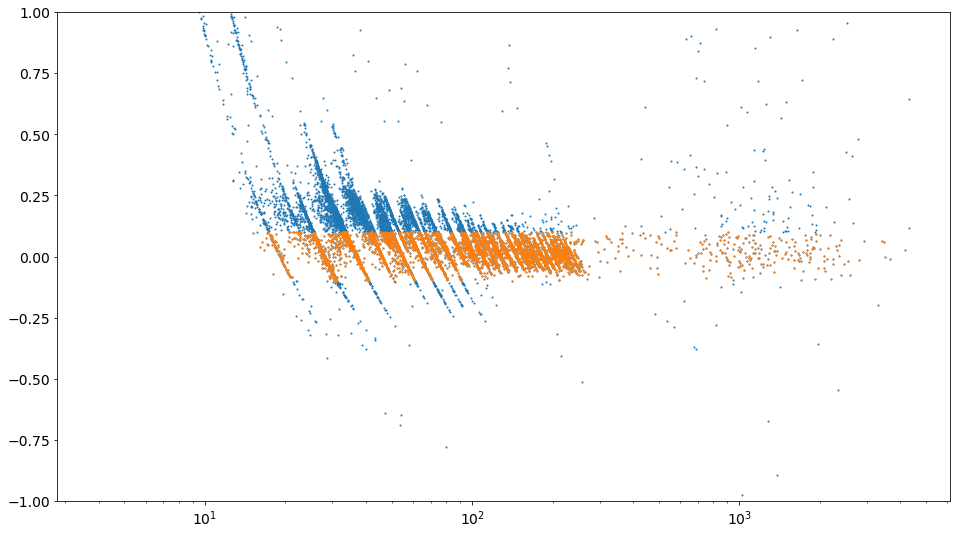

In [13]:
fig, ax = subplots(figsize = (16,9))
ax.scatter(tgtListRed['numax'], rnumax, s = 1)
ax.scatter(tgtListRed['numax'][idxnumax], rnumax[idxnumax], s = 1)
ax.set_xscale('log')
ax.set_ylim(-1,1)

(-0.5, 0.5)

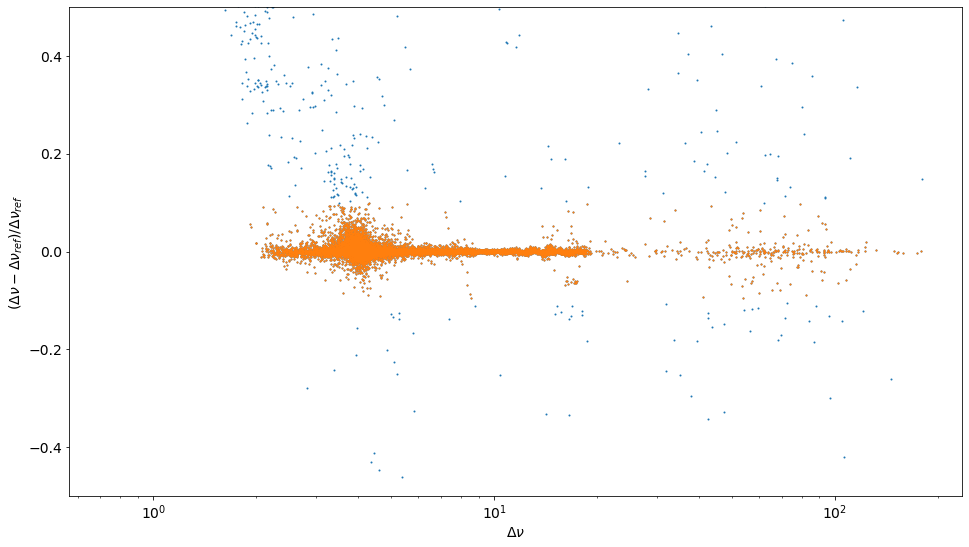

In [14]:
fig, ax = subplots(figsize = (16,9))
ax.scatter(tgtListRed['dnu'], rdnu, s = 1)
ax.scatter(tgtListRed['dnu'][idxdnu], rdnu[idxdnu], s = 1)
ax.set_xscale('log')
ax.set_ylabel(r'($\Delta\nu - \Delta\nu_{ref})/ \Delta\nu_{ref}$')
ax.set_xlabel(r'$\Delta\nu$')
ax.set_ylim(-0.5,0.5)

In [15]:
len(rdnu)

16053

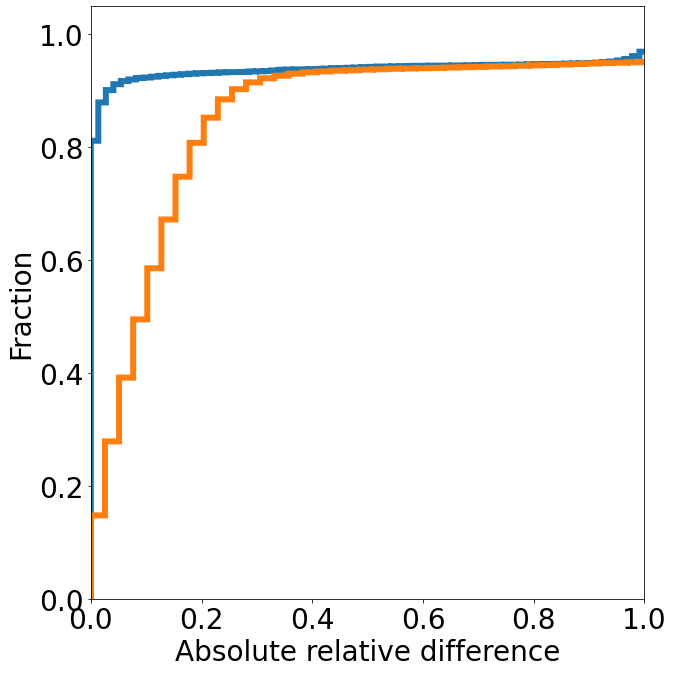

In [16]:
rcParams['font.size'] = 28
fig, ax = subplots(figsize = (10,10))
ax.hist(abs(rdnu)    , cumulative=True, bins = 1000, density=True, histtype='step', label =r'$\Delta\nu$ relative to Yu et al.', lw = 6)
ax.hist(abs(rnumax), cumulative=True, bins = 1000, density=True, histtype='step', label =r'$\nu_{max}$ relative to Yu et al.', lw = 6)
ax.set_xlabel('Absolute relative difference')
ax.set_ylabel('Fraction')

#ax.text(x=0.4, y=0.65, s=r'Sample size: ' +f'{len(rdnu)}', fontsize = 18)
#ax.text(x=0.4, y=0.6, s=r'Relative $\Delta\nu$ ' +f'< {limit*100}%: '  + f'{np.round(recoveryDnu*100,2)}%', fontsize = 18)
#ax.text(x=0.4, y=0.55, s=r'Relative $\nu_{max}$ ' +f'< {limit*100}%: ' + f'{np.round(recoveryNumax*100  ,2)}%', fontsize = 18)

ax.set_xlim(0,1)
fig.tight_layout()
#fig.savefig('recovery.png')

In [ ]:
tgt_list = pd.read_csv('/home/nielsemb/work/Bluebear_projects/getGlobal/the_big_solar_like_oscillator_list.csv')

In [ ]:
Tred = 8907.*(tgt_list['numax']/3050.)**0.11*(tgt_list['teff']/5777.)**-0.47
    
beta = 1.0 - np.exp(-(Tred-tgt_list['teff'])/1250.)


teff_beta0 = (9200 * (np.sort(tgt_list['numax'])/3050)**0.11 * 5777**0.47)**(1./1.47)

figure()
scatter(tgt_list['teff'], tgt_list['numax'], s = 2, label='Kepler samples')
plot(teff_beta0, np.sort(tgt_list['numax']), color = 'C1', label=r'$\beta$=0')
#xscale('log')
yscale('log')
ylabel(r'$\nu_{max}$')
xlabel('Teff [K]')
legend()
savefig('betazero.png')

In [ ]:
Teff_test = np.linspace(3000,8000)
numax_beta0 = ((Teff_test/9300) * (Teff_test/5777)**0.47)**(1/0.11)*3050
numax_beta1 = ((Teff_test/5500) * (Teff_test/5777)**0.47)**(1/0.11)*3050

print(numax_beta0)
figure()
scatter(tgt_list['teff'], tgt_list['numax'], s = 2, label='Kepler samples')
plot(Teff_test, numax_beta0, color = 'C1', label=r'$\beta$=0')
plot(Teff_test, numax_beta1, color = 'C3', label=r'$\beta$=silly')

#xscale('log')
yscale('log')
ylabel(r'$\nu_{max}$')
xlabel('Teff [K]')
legend()
savefig('betazero.png')

In [ ]:
numax_beta1 = ((5777/5500) * (5777/5777)**0.47)**(1/0.11)*3050
print(numax_beta1)

In [ ]:
teff_beta0 = (9500 * (10**pbjamPrior['numax']/3050)**0.11 * 5777**0.47)**(1./1.47)

figure()
scatter(10**pbjamPrior['numax'], 10**pbjamPrior['teff'], s = 2)
scatter(10**pbjamPrior['numax'], teff_beta0, s = 2)

xscale('log')
xscale('log')

In [ ]:
figure()
scatter(pbjamPrior['numax'], pbjamPrior['env_height'], c=pbjamPrior['teff'], s = 2)

In [ ]:
import scipy.special as sc

In [ ]:
dof = 200000
scale = 1./dof
np.log(sc.chdtrc(dof, 1.9/scale))

In [ ]:
numax_i, dnu_i, H_i, w_i, B_i = numaxGuess, gd.dnuScale(numaxGuess), max(acf[5:]), np.log10(0.2), np.mean(acf[-5:])



pos = np.array([numax_i, dnu_i, H_i, w_i, B_i]) + 1e-2*np.random.randn(nwalkers, ndim)

In [ ]:
nwalkers = 50
ndim = 5

In [ ]:
numaxGuess = 2
n = np.random.normal(numaxGuess, 10, nwalkers)
idx = (n < fb[0]) + (n > fb[-1])
while len(n[idx]) > 0:
    n[idx] = np.random.normal(numaxGuess, 1.5*numaxGuess, len(n[idx]))
    idx = (n < fb[0]) + (n > fb[-1])

#
#while len(n[idx]) > 0
# numax_i = np.random.uniform(fb[0], fb[-1], nwalkers)
# dnu_i = gd.dnuScale(numax_i)
# H_i = max(acf[5:]) + 1e-2*np.random.randn(nwalkers)
# w_i = np.log10(0.2) + 1e-2*np.random.randn(nwalkers)
# B_i = np.mean(acf[-5:]) + 1e-2*np.random.randn(nwalkers)
# pos = np.vstack((numax_i, dnu_i, H_i,w_i,B_i)).T

In [ ]:
def getTrimmedACF(f, p, b, freqBinSize=1):
    fb, pb, bb, dfb, Nbin = gd.binTheSpectrum(f, p, b, freqBinSize)
    snr = pb/bb
    plot(fb,snr)
    lags, acf = gd.fftAcf(fb, snr/np.nanmean(snr))
    
    # Set the limit to consider in the ACF. This is 3 times the Dnu corresponding
    # to the Nyquist frequency times a bit. Should be enough to include 
    # everything of interest.
    lmax = 3*gd.dnuScale(fb[-1])  
    idx = (0 < lags) & (lags < lmax)
    return lags[idx], acf[idx]

def get_one_ACF_mu_cov(ACF):
    
    N = len(ACF)
    
    ones = np.ones(N-1)
    
    C = np.diag(ones)
    
    #C = C[::-1]
    
    #C += np.diag(ones)
    
    C[C>1] = 1
    
    C[C==0] = 0.02
    
    C *= 3*N
    return N, C

In [ ]:
lags, acf = getTrimmedACF(f, p, b, freqBinSize = 1)
_, C = get_one_ACF_mu_cov(acf)

In [ ]:
def normlogpdf(x, mu, sigma=None, normed=True):
    """ Gaussian log probability for x ~ N(mu,sigma)
    
    Computes the logarithmic probability density of x, 
    given a mean mu and a covariance matrix S.
        
    Parameters
    ----------
    x : array
        Points at which to evaluate the log-pdf
    mu : array
        Mean values of the pdf. 
    S : array
        Covariance matrix of shape NxN where N is the
        length x. Can be a numpy array or a scipy.sparse
        matrix.
    """
    
    if isinstance(sigma, (np.float, np.int)):
        if normed:
            return np.sum(-np.log(np.sqrt(2*np.pi)*sigma) - 0.5*(x-mu)**2/sigma**2)
        else:
            return -0.5*(x-mu)**2/sigma**2
        
    nx = sigma.shape[0]
    norm_coeff = nx*np.log(2*np.pi)+np.linalg.slogdet(sigma.toarray())[1]

    err = x-mu
    if sp.issparse(sigma):
        numerator = spln.spsolve(sigma, err).T.dot(err)
    else:
        numerator = np.linalg.solve(sigma, err).T.dot(err)

    return -0.5*(norm_coeff+numerator)

In [ ]:
plot(lags,acf)

In [ ]:
from matplotlib.pyplot import *
from scipy.stats import chi2
import globalDetFunctions as gd


In [ ]:
def Gaussian(x, mu, sigma):
    return np.exp(-(x-mu)**2/(2*sigma**2))
def lorentzian(x, nu, Gamma, A):
    return A*Gamma/(1+2/Gamma**2 * (x-nu)**2)

In [ ]:

mu = 3500
sigma = 300
nu = np.linspace(2000, 5500, 5000)

A = 10
Dnu = 150

P=np.ones_like(nu)
for i in range(1, int(nu[-1]/Dnu)):
    nu0 = i*Dnu
    
    Gamma =  0.004*(nu0-2500) + 0.55
    
    P += Gaussian(nu, mu, sigma) * lorentzian(nu, nu0, Gamma, A)
    P += Gaussian(nu, mu, sigma) * lorentzian(nu, nu0+0.5*Dnu, Gamma, 1.5*A)
    P += Gaussian(nu, mu, sigma) * lorentzian(nu, nu0-0.1*Dnu, Gamma, 0.5*A)

P -= P[-1]-1
    
SNR, SNR_pred, dof = np.array([gd.getSNR(numax, nu, P, np.ones_like(P), 5350, nu[-1], 1) for numax in nu]).T
    
figure(figsize = (16,9))
plot(nu, P)
plot(nu, 20*SNR+1)
xlim(2000,5000)    

In [ ]:
plot(nu, np.log10(SNR_pred))